## AMPLITUDE RUNNING MEAN

In [1]:
import numpy as np
import pandas as pd
import datetime
from scipy import stats

In [2]:
def runing_mean(ddt,window=5):

        run  = pd.DataFrame([])
        st   = ddt.index[0]
        #print(ddt.index[-1])
        for i in range(1,100000):
            if (st <= ddt.index[-window]):

                dt   = ddt[(ddt.index >= st) & (ddt.index  < st+datetime.timedelta(days=window-1))]

                dtt  = pd.DataFrame(dt.mean()).T
                #dtt['Datetime'] = st+datetime.timedelta(days=np.round(window/2,0)) 
                dtt['Datetime'] = st+datetime.timedelta(days= int(window/2.0))
                dtt.set_index('Datetime', inplace=True)
                run  = run.append(dtt)
                st   = st + datetime.timedelta(days=1)
                #print(i,st)
        return run
    
    
    
def lowpass_scipy(signal,sample_freq,time_period,keep_mean):
    import numpy as np
    import scipy as sc
    from scipy import fftpack
    
    lowpass_signal=np.zeros(signal.shape)
    if any(np.isnan(signal)):
        raise ValueError('There is NaN in the signal')
    else:
        hf = 1./time_period

        temp_fft = sc.fftpack.fft(signal)

        fftfreq = np.fft.fftfreq(len(signal),sample_freq) ### daily data it is 1./365 ## monthly data 1./12 ## yearly data=1
          
        i1 = np.abs(fftfreq) >= hf  
        
        temp_fft[i1] = 0
        if not(keep_mean):
            temp_fft[0]=0
        lowpass_signal= np.real_if_close(sc.fftpack.ifft(temp_fft))
    
    return lowpass_signal



def smooth(x,window_len=11,window='hanning'):
    ##https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.
    output:
        the smoothed signal
        
    example:
    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y



def theta1_cal( pc1, pc2 ):
    theta1           =  np.zeros(pc2.size)
    angle180         =  np.arctan2(-pc2, -pc1) * 180 / np.pi
    indNeg           =  np.where(angle180<0)[0]
    angle360         = angle180
    angle360[indNeg] = angle180[indNeg] + 360
    theta1           = np.around( ( angle360 + 22.5 ) * 8 / 360 )
    return theta1

In [3]:
window = 11 ## running mean window = 3year 

## Convolution 1D

In [4]:
df1 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/conv1d/ensamble4/ensamble_conv1d_jgrjd_rmm1_p1.csv')
df1.columns = ['Datetime','rmm1']
df1.index = pd.to_datetime(df1.Datetime)
df1 = df1.drop('Datetime',axis=1)

df2 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/conv1d/ensamble4/ensamble_conv1d_jgrjd_rmm2.csv')
df2.columns = ['Datetime','rmm2']
df2.index = pd.to_datetime(df2.Datetime)
df2 = df2.drop('Datetime',axis=1)

st = 1906
en = 2014

d1_conv = df1['rmm1'][(df1.index >= datetime.datetime(st,1,1)) & (df1.index  <= datetime.datetime(en,12,31))]
d2_conv = df2['rmm2'][(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]

mjo_ind_conv = (d1_conv**2+d2_conv**2)**0.5
phase1_conv_hist = theta1_cal( d1_conv, d2_conv )

mjo_ind_conv_3yr = runing_mean(pd.DataFrame(mjo_ind_conv),window=365*window)

d1_conv.std(),d2_conv.std()

(0.9281949178257728, 0.9215071426743987)

In [5]:
# smooth(mjo_ind_conv.values,window=365*window)[]

## MLR

In [6]:
df1 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/multiple_regression/rmm1_MLR_org.txt')
df1.columns = ['Datetime','rmm1']
df1.index = pd.to_datetime(df1.Datetime)
df1 = df1.drop('Datetime',axis=1)
df1 = df1[['rmm1']]/df1['rmm1'].loc['1979-01-01':'2008-12-31'].std()


df2 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/multiple_regression/rmm2_MLR_org.txt')
df2.columns = ['Datetime','rmm2']
df2.index = pd.to_datetime(df2.Datetime)
df2 = df2.drop('Datetime',axis=1)
df2 = df2[['rmm2']]/df2['rmm2'].loc['1979-01-01':'2008-12-31'].std()


st = 1906
en = 2014

d1_mlr = df1['rmm1'][(df1.index >= datetime.datetime(st,1,1)) & (df1.index  <= datetime.datetime(en,12,31))]
d2_mlr = df2['rmm2'][(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]

mjo_ind_mlr = (d1_mlr**2+d2_mlr**2)**0.5
phase1_mlr_hist = theta1_cal( d1_mlr, d2_mlr )

mjo_ind_mlr_3yr = runing_mean(pd.DataFrame(mjo_ind_mlr),window=365*window)
d1_mlr.std(),d2_mlr.std()

(0.92118476655339, 0.9176555601678572)

## oliver

In [7]:
df2 = pd.read_csv('/home/cccr/supriyo/panini/data/rmm_oliver_V3.csv')
df2['Datetime'] = df2.year.map(str) + '-' + df2.month.map(str) + '-'+df2.day.map(str) 
df2.index = pd.to_datetime(df2.Datetime)
df2 = df2.drop('Datetime',axis=1)
df2['IHR1'] = df2[['IHR1']]/df2['IHR1'].loc['1979-01-01':'2008-12-31'].std()
df2['IHR2'] = df2[['IHR2']]/df2['IHR2'].loc['1979-01-01':'2008-12-31'].std()


d1_ol = df2['IHR1'][(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]
d2_ol = df2['IHR2'][(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]

mjo_ind_ol = (d1_ol**2+d2_ol**2)**0.5
phase1_ol_hist = theta1_cal( d1_ol, d2_ol )


mjo_ind_ol_3yr = runing_mean(pd.DataFrame(mjo_ind_ol),window=365*window)
d1_ol.std(),d2_ol.std()

(0.9135182428108564, 0.9108264797186324)

## JRA55

In [8]:
df_jra55 = pd.read_excel('/home/cccr/supriyo/panini/filtered_data/data/jra55_mjo_index.xlsx')
df_jra55['Datetime'] = df_jra55.year.map(str) + '-' + df_jra55.month.map(str) + '-'+df_jra55.day.map(str) 
df_jra55.index = pd.to_datetime(df_jra55.Datetime)
df_jra55 = df_jra55.drop('Datetime',axis=1)

df_jra55['rmm1'] = df_jra55[['rmm1']]/df_jra55['rmm1'].loc['1979-01-01':'2008-12-31'].std()
df_jra55['rmm2'] = df_jra55[['rmm2']]/df_jra55['rmm2'].loc['1979-01-01':'2008-12-31'].std()

st = 1958
en = 2014

d1_jra55 = df_jra55['rmm1'][(df_jra55.index >= datetime.datetime(st,1,1)) & (df_jra55.index  <= datetime.datetime(en,12,31))]
d2_jra55 = df_jra55['rmm2'][(df_jra55.index >= datetime.datetime(st,1,1)) & (df_jra55.index  <= datetime.datetime(en,12,31))]

mjo_ind_jra = (d1_jra55**2+d2_jra55**2)**0.5
phase1_jra_hist = theta1_cal( d1_jra55, d2_jra55 )


mjo_ind_jra_3yr = runing_mean(pd.DataFrame(mjo_ind_jra),window=365*window)
d1_jra55.std(),d2_jra55.std()



(0.9642590235055093, 0.9488965203045685)

## SVR 

In [9]:
df_svr11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/SVR/rmm1_1905_2015_svr_org_new.txt')

df_svr11.columns = ['Datetime','rmm1']
df_svr11.index = pd.to_datetime(df_svr11.Datetime)
df_svr11 = df_svr11.drop('Datetime',axis=1)
df_svr11 = df_svr11[['rmm1']]/df_svr11['rmm1'].loc['1979-01-01':'2008-12-31'].std()


df_svr22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/SVR/rmm2_1905_2015_svr_org_new.txt')
df_svr22.columns = ['Datetime','rmm2']
df_svr22.index = pd.to_datetime(df_svr22.Datetime)
df_svr22 = df_svr22.drop('Datetime',axis=1)
df_svr22 = df_svr22[['rmm2']]/df_svr22['rmm2'].loc['1979-01-01':'2008-12-31'].std()

st = 1906
en = 2014

d1_svr = df_svr11['rmm1'][(df_svr11.index >= datetime.datetime(st,1,1)) & (df_svr11.index  <= datetime.datetime(en,12,31))]
d2_svr = df_svr22['rmm2'][(df_svr22.index >= datetime.datetime(st,1,1)) & (df_svr22.index  <= datetime.datetime(en,12,31))]

mjo_ind_svr = (d1_svr**2+d2_svr**2)**0.5
phase1_svr_hist = theta1_cal( d1_svr, d2_svr )


mjo_ind_svr_3yr = runing_mean(pd.DataFrame(mjo_ind_svr),window=365*window)
d1_svr.std(),d2_svr.std()

(0.9209595759355709, 0.9198550708777308)

## Conv2D

In [10]:
df11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/deep_CNN/rmm1_conv_minmaxscale_1905_2015.csv')

df11.columns = ['Datetime','rmm1']
df11.index = pd.to_datetime(df11.Datetime)
df11_c2d = df11.drop('Datetime',axis=1)
df11_c2d = df11_c2d[['rmm1']]/df11_c2d['rmm1'].loc['1979-01-01':'2008-12-31'].std()


st = 1906
en = 2014

df22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/deep_CNN/rmm2_conv_minmaxscale_1905_2015.csv')

df22.columns = ['Datetime','rmm2']
df22.index = pd.to_datetime(df22.Datetime)
df22_c2d = df22.drop('Datetime',axis=1)
df22_c2d = df22_c2d[['rmm2']]/df22_c2d['rmm2'].loc['1979-01-01':'2008-12-31'].std()


d1_c2d = df11_c2d['rmm1'][(df11_c2d.index >= datetime.datetime(st,1,1)) & (df11_c2d.index  <= datetime.datetime(en,12,31))]
d2_c2d = df22_c2d['rmm2'][(df22_c2d.index >= datetime.datetime(st,1,1)) & (df22_c2d.index  <= datetime.datetime(en,12,31))]

mjo_ind_c2d = (d1_c2d**2+d2_c2d**2)**0.5
phase1_c2d_hist = theta1_cal( d1_c2d, d2_c2d )

mjo_ind_c2d_3yr = runing_mean(pd.DataFrame(mjo_ind_c2d),window=365*window)
d1_c2d.std(),d2_c2d.std()

(0.9091333916070523, 0.9179948161945628)

## WH04 RMM 

In [11]:
rmm         = pd.read_csv('/home/cccr/supriyo/panini/data_jgrjd/rmm_index.csv')
rmm.columns = ['date','rmm1','rmm2']

rmm.index   = pd.to_datetime(rmm.date)
rmm = rmm.drop('date',axis=1)

st =1979 ;en =2014

d1_wh04 = rmm['rmm1'].loc[str(st)+'-01-01':str(en)+'-12-31']
d2_wh04 = rmm['rmm2'].loc[str(st)+'-01-01':str(en)+'-12-31']
d11=lowpass_scipy(d1_wh04,1,10,1)
d11 = pd.Series(d11,index=d1_wh04.index)

d22=lowpass_scipy(d2_wh04,1,10,1)
d22 = pd.Series(d22,index=d2_wh04.index)

mjo_ind_wh04 = (d11**2+d22**2)**0.5
phase1_wh04_hist = theta1_cal( d1_wh04, d2_wh04 )


mjo_ind_wh04_3yr = runing_mean(pd.DataFrame(mjo_ind_wh04),window=365*window)

In [12]:
window

11

In [13]:
df_amp_all=pd.concat([mjo_ind_conv,mjo_ind_ol,mjo_ind_wh04,mjo_ind_mlr,mjo_ind_svr,mjo_ind_c2d,mjo_ind_jra],axis=1)
df_phase_all=pd.concat([phase1_conv_hist,phase1_ol_hist,phase1_wh04_hist,phase1_mlr_hist,phase1_svr_hist,phase1_c2d_hist,phase1_jra_hist],axis=1)
df_amp_all.columns = ['CNN-1D','OT12','WH04','MLR','SVR','CNN-2D','JRA55']
df_phase_all.columns = ['CNN-1D','OT12','WH04','MLR','SVR','CNN-2D','JRA55']


In [14]:
df_amp_all_3yr=pd.concat([mjo_ind_conv_3yr,mjo_ind_ol_3yr,mjo_ind_wh04_3yr,mjo_ind_mlr_3yr,mjo_ind_svr_3yr,mjo_ind_c2d_3yr,mjo_ind_jra_3yr],axis=1)
df_amp_all_3yr.columns = ['CNN-1D','OT12','WH04','MLR','SVR','CNN-2D','JRA55']


In [15]:
# %store -z
%store df_amp_all_3yr

Stored 'df_amp_all_3yr' (DataFrame)


In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig,ax=plt.subplots(1,1,figsize=(20,5))
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 20
plt.rcParams['image.cmap'] = 'seismic'


ax.plot(df_amp_all_3yr.iloc[:,0],'-',label='CNN-1D')
ax.plot(df_amp_all_3yr.iloc[:,1],'-',label='OT12',alpha=0.8)
ax.plot(df_amp_all_3yr.iloc[:,2],'k',label='WH04',alpha=0.5)

ax.plot(df_amp_all_3yr.iloc[:,3],'-',label='MLR',color= 'red',alpha=0.5)
ax.plot(df_amp_all_3yr.iloc[:,4],'-',label='SVR',color='green',alpha=0.5)
ax.plot(df_amp_all_3yr.iloc[:,6],'-',label='JRA55',color='cyan',alpha=0.8)


ax.set_ylim([0.9,1.5])
ax.set_xlim([datetime.datetime(1905,6,1),datetime.datetime(2015,6,1)])


fig.text(0.5, -0.04, 'Year', ha='center')
fig.text(0.07, 0.5, '3yr running amplitude', va='center', rotation='vertical')

# ax.axvspan(datetime.datetime(1923,6,1),datetime.datetime(1945,6,1),color = 'r',alpha = 0.1)
# ax.axvspan(datetime.datetime(1945,6,1),datetime.datetime(1977,6,1),color = 'b',alpha = 0.1)
# ax.axvspan(datetime.datetime(1977,6,1),datetime.datetime(1999,6,1),color = 'r',alpha = 0.1)# ax.axvspan(1998,2012,alpha = 0.1)
# ax.axvspan(datetime.datetime(1999,6,1),datetime.datetime(2012,6,1),color = 'b',alpha = 0.1)

plt.legend(ncol=3)
plt.title('11 year running MJO amplitude')
ax = plt.gca()
from matplotlib.ticker import AutoMinorLocator
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=12))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.gcf().autofmt_xdate() # Rotation
ax.tick_params(which='major', length=10, width=1, direction='inout')
ax.tick_params(which='minor', length=5, width=1, direction='in')

ax.xaxis.set_ticks_position('both')  # Adding ticks to both top and bottom
ax.xaxis.set_tick_params(direction='inout', which='top') 
ax.yaxis.set_ticks_position('both')  # Adding ticks to both top and bottom
ax.yaxis.set_tick_params(direction='inout', which='right')

plt.show()
# fig.savefig('/home/cccr/supriyo/panini/very_low_jgrjd_figure4.png',dpi=300)


/home/cccr/supriyo/.conda/envs/environment1/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 2000x500 with 1 Axes>

## trend in running mean amplitude

In [37]:
for i in [0,1,2,3,4,6]:
    temp= df_amp_all_3yr.iloc[:,i].dropna()
    res = stats.linregress(np.arange(1,len(temp)+1),temp)
    print(res[0]*36500,res[0]*36500/res[1])
    print(res[3])
    

0.26618114134146037 0.2582228247555966
0.0
0.3098022903281863 0.3154768839311542
0.0
0.17639470179995748 0.14249430902365115
0.0
0.2989616250105661 0.3009939675853819
0.0
0.2991750678597501 0.29971438719359655
0.0
0.5429461446677154 0.501897832339801
0.0


## trend in actual amplitude

In [38]:
for i in [0,1,2,3,4,6]:
    temp= df_amp_all.iloc[:,i].dropna()
    res = stats.linregress(np.arange(1,len(temp)+1),temp)
    print(res[0]*36500,res[0]*36500/res[1],res[3])
#     print(res[3])

0.23548780552260473 0.22918855784553346 6.105254011027319e-130
0.2704199122813951 0.2764240760359591 1.0946937125419344e-161
-0.022952494889381905 -0.01831008430982448 0.6714233268152274
0.27055562519156584 0.27421323879157133 7.436941056052143e-159
0.27104319086699963 0.2736158494516867 9.032605509701016e-162
0.4115136061989915 0.38121301918532496 1.420208713323962e-53


In [39]:
for i in [0,1,2,3,4,6]:
    temp= df_amp_all['1959-01-01':'2015-12-31'].iloc[:,i].dropna()
    res = stats.linregress(np.arange(1,len(temp)+1),temp)
    print(res[0]*36500,res[0]*36500/res[1],res[3])
#     print(res[3])

0.0823142520516499 0.06847448904916438 0.0028028009212979496
0.046997738741106125 0.03939025196556645 0.10150746904511308
-0.022952494889381905 -0.01831008430982448 0.6714233268152274
0.11600365648481019 0.09834898574837114 6.28014476429199e-05
0.09536845614310979 0.08016969215278061 0.0008761479454861874
0.43693461463855804 0.4072108393039483 7.687059833337478e-58


## Correlation with WH04

In [40]:
print(np.corrcoef(df_amp_all.iloc[:,0].loc['1982-01-01':'2012-12-31'],df_amp_all.iloc[:,2].loc['1982-01-01':'2012-12-31'])[0,1])
print(np.corrcoef(df_amp_all.iloc[:,1].loc['1982-01-01':'2012-12-31'],df_amp_all.iloc[:,2].loc['1982-01-01':'2012-12-31'])[0,1])
print(np.corrcoef(df_amp_all.iloc[:,2].loc['1982-01-01':'2012-12-31'],df_amp_all.iloc[:,2].loc['1982-01-01':'2012-12-31'])[0,1])
print(np.corrcoef(df_amp_all.iloc[:,3].loc['1982-01-01':'2012-12-31'],df_amp_all.iloc[:,2].loc['1982-01-01':'2012-12-31'])[0,1])
print(np.corrcoef(df_amp_all.iloc[:,4].loc['1982-01-01':'2012-12-31'],df_amp_all.iloc[:,2].loc['1982-01-01':'2012-12-31'])[0,1])
print(np.corrcoef(df_amp_all.iloc[:,5].loc['1982-01-01':'2012-12-31'],df_amp_all.iloc[:,2].loc['1982-01-01':'2012-12-31'])[0,1])
print(np.corrcoef(df_amp_all.iloc[:,6].loc['1982-01-01':'2012-12-31'],df_amp_all.iloc[:,2].loc['1982-01-01':'2012-12-31'])[0,1])

0.755920515222103
0.6903879343258755
1.0
0.6949751523248919
0.6976270101832301
0.8595604790252948
0.8085269438251058


In [41]:
print(np.corrcoef(df_amp_all_3yr.iloc[:,0].loc['1985-01-01':'2012-12-31'],df_amp_all_3yr.iloc[:,2].loc['1985-01-01':'2012-12-31'])[0,1])
print(np.corrcoef(df_amp_all_3yr.iloc[:,1].loc['1985-01-01':'2012-12-31'],df_amp_all_3yr.iloc[:,2].loc['1985-01-01':'2012-12-31'])[0,1])
print(np.corrcoef(df_amp_all_3yr.iloc[:,2].loc['1985-01-01':'2012-12-31'],df_amp_all_3yr.iloc[:,2].loc['1985-01-01':'2012-12-31'])[0,1])
print(np.corrcoef(df_amp_all_3yr.iloc[:,3].loc['1985-01-01':'2012-12-31'],df_amp_all_3yr.iloc[:,2].loc['1985-01-01':'2012-12-31'])[0,1])
print(np.corrcoef(df_amp_all_3yr.iloc[:,4].loc['1985-01-01':'2012-12-31'],df_amp_all_3yr.iloc[:,2].loc['1985-01-01':'2012-12-31'])[0,1])
print(np.corrcoef(df_amp_all_3yr.iloc[:,5].loc['1985-01-01':'2012-12-31'],df_amp_all_3yr.iloc[:,2].loc['1985-01-01':'2012-12-31'])[0,1])
print(np.corrcoef(df_amp_all_3yr.iloc[:,6].loc['1985-01-01':'2012-12-31'],df_amp_all_3yr.iloc[:,2].loc['1985-01-01':'2012-12-31'])[0,1])

0.639240668976345
0.6602526800588534
1.0
0.7863966378391503
0.8101030999944759
0.8152078586122654
0.8712995622792684


In [42]:
df_amp_all.corr()

,CNN-1D,OT12,WH04,MLR,SVR,CNN-2D,JRA55
CNN-1D,1.000000,0.840911,0.749366,0.864570,0.866474,0.654815,0.665753
OT12,0.840911,1.000000,0.679510,0.953729,0.943852,0.663462,0.622569
WH04,0.749366,0.679510,1.000000,0.687500,0.690606,0.850450,0.810543
MLR,0.864570,0.953729,0.687500,1.000000,0.972870,0.665360,0.609853
SVR,0.866474,0.943852,0.690606,0.972870,1.000000,0.671198,0.617151
CNN-2D,0.654815,0.663462,0.850450,0.665360,0.671198,1.000000,0.691937
JRA55,0.665753,0.622569,0.810543,0.609853,0.617151,0.691937,1.000000


#### Probability distribution

Text(0.04, 0.5, 'Percentage(%)')

<Figure size 432x288 with 0 Axes>

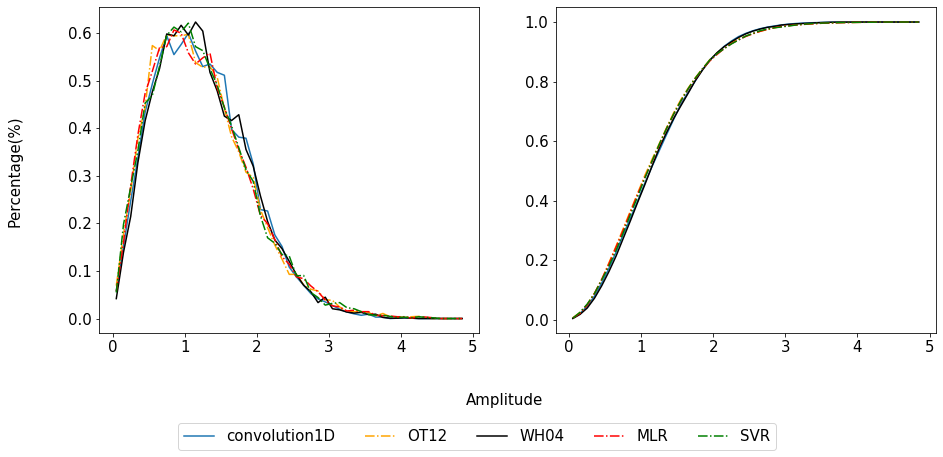

In [43]:
bins= np.arange(0,5,0.1)
n1_conv,x1_conv,_=plt.hist(mjo_ind_conv.loc['1979-01-01':'2015-12-31'],bins=bins,density=True,alpha=0.5,histtype='step',label='observed')
n1_ol,x1_ol,_=plt.hist(mjo_ind_ol.loc['1979-01-01':'2015-12-31'],bins=bins,density=True,alpha=0.5,histtype='step',label='observed')
n1_wh04,x1_wh04,_=plt.hist(mjo_ind_wh04.loc['1979-01-01':'2015-12-31'],bins=bins,density=True,alpha=0.5,histtype='step',label='ol')
n1_mlr,x1_mlr,_=plt.hist(mjo_ind_mlr.loc['1979-01-01':'2015-12-31'],bins=bins,density=True,alpha=0.5,histtype='step',label='observed')
n1_svr,x1_svr,_=plt.hist(mjo_ind_svr.loc['1979-01-01':'2015-12-31'],bins=bins,density=True,alpha=0.5,histtype='step',label='observed')

plt.clf()


n2_conv,x1_conv,_=plt.hist(mjo_ind_conv.loc['1979-01-01':'2015-12-31'],cumulative =True,bins=bins,density=True,alpha=0.5,histtype='step',label='observed')
n2_ol,x1_ol,_=plt.hist(mjo_ind_ol.loc['1979-01-01':'2015-12-31'],cumulative =True,bins=bins,density=True,alpha=0.5,histtype='step',label='observed')
n2_wh04,x1_wh04,_=plt.hist(mjo_ind_wh04.loc['1979-01-01':'2015-12-31'],cumulative =True,bins=bins,density=True,alpha=0.5,histtype='step',label='ol')
n2_mlr,x1_mlr,_=plt.hist(mjo_ind_mlr.loc['1979-01-01':'2015-12-31'],cumulative =True,bins=bins,density=True,alpha=0.5,histtype='step',label='observed')
n2_svr,x1_svr,_=plt.hist(mjo_ind_svr.loc['1979-01-01':'2015-12-31'],cumulative =True,bins=bins,density=True,alpha=0.5,histtype='step',label='observed')

plt.clf()

fig,ax=plt.subplots(1,2,figsize=(15,6))
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 15
plt.rcParams['image.cmap'] = 'seismic'

bin_centers = 0.5*(x1_conv[1:]+x1_conv[:-1])
ax[0].plot(bin_centers,n1_conv,label='convolution1D')
ax[0].plot(bin_centers,n1_ol,'-.',color='orange',label='OT12')
ax[0].plot(bin_centers,n1_wh04,'k',label='WH04')
ax[0].plot(bin_centers,n1_mlr,'-.',color='r',label='MLR')
ax[0].plot(bin_centers,n1_svr,'-.',color='g',label='SVR')



ax[1].plot(bin_centers,n2_conv,label='convolution1D')
ax[1].plot(bin_centers,n2_ol,'-.',color='orange',label='OT12')
ax[1].plot(bin_centers,n2_wh04,'k',label='WH04')
ax[1].plot(bin_centers,n2_mlr,'-.',color='r',label='MLR')
ax[1].plot(bin_centers,n2_svr,'-.',color='g',label='SVR')

# bin_centers3 = 0.5*(x3[1:]+x3[:-1])
# plt.plot(bin_centers3,n3,'b',label='oliver')
plt.legend(bbox_to_anchor=(0.6,-0.38),loc="lower right",ncol=5)
fig.text(0.5, -0.04, 'Amplitude', ha='center')
fig.text(0.04, 0.5, 'Percentage(%)', va='center', rotation='vertical')

## trend in winter and Summer #

In [44]:
def winter_amp(phase_rmm,amp1_rmm,s_year,e_year):
    
    n = e_year-s_year
    aa_winter = np.zeros(n,)
    phase_amp_winter = np.zeros((n,8))
    
    for i in np.arange(s_year,e_year,1):
        aa_winter[i-s_year]= amp1_rmm.loc[str(i)+'-11-01':str(i+1)+'-04-30'].mean()
        temp_amp = amp1_rmm.loc[str(i)+'-11-01':str(i+1)+'-04-30']
        temp_phase = phase_rmm.loc[str(i)+'-11-01':str(i+1)+'-04-30']

        for j in np.arange(1,9,1):
            phase_amp_winter[i-s_year,j-1] = temp_amp[temp_phase==j].mean()
    
    return aa_winter,phase_amp_winter


def summer_amp(phase_rmm,amp1_rmm,s_year,e_year):
    
    n = e_year-s_year
    aa_summer = np.zeros(n,)
    phase_amp_summer = np.zeros((n,8))
    
    for i in np.arange(s_year,e_year,1):
        aa_summer[i-s_year]= amp1_rmm.loc[str(i)+'-05-01':str(i+1)+'-10-31'].mean()
        temp_amp = amp1_rmm.loc[str(i)+'-05-01':str(i+1)+'-10-31']
        temp_phase = phase_rmm.loc[str(i)+'-05-01':str(i+1)+'-10-31']

        for j in np.arange(1,9,1):
            phase_amp_summer[i-s_year,j-1] = temp_amp[temp_phase==j].mean()
    
    return aa_summer,phase_amp_summer




## trend in average winter amplitude

0.7112703253030603 1.1153478026476715 7.330076546749489e-21


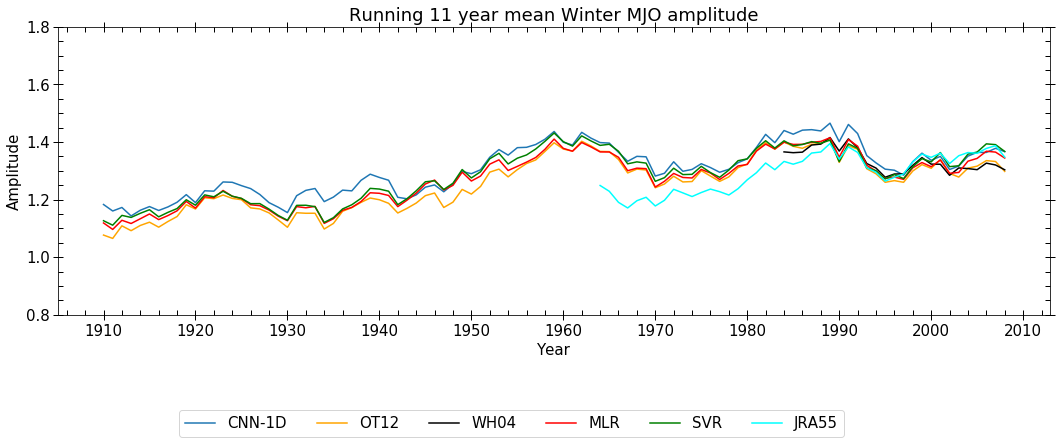

In [45]:
def draw_mean_amp_trend_wintr():
    window = 11;
    ww     = 2*(window//2);

    list1  = [0,1,2,3,4,6]

    fig,ax  = plt.subplots(1,1,figsize=(15,7))
    plt.rcParams['font.weight'] = 'normal'
    plt.rcParams['font.size'] = 15
    plt.rcParams['image.cmap'] = 'seismic'

    c       = ['C0','orange','k','r','g','cyan']

    kk    =   0
    
    list = np.arange(1910,2019,10).tolist()
    s    = [str(i) for i in list] 
    mean_phase_trend = np.zeros((6,109))
    ind_trend = np.zeros(6)
    
    lab = ['CNN-1D','OT12','WH04','MLR','SVR','','JRA55']
    
    for k in list1:
        if k==2:
            aa_winter,_ = winter_amp(df_phase_all.iloc[:,k],df_amp_all.iloc[:,k],1979,2014) 
        elif k==6:
            aa_winter,_ = winter_amp(df_phase_all.iloc[:,k],df_amp_all.iloc[:,k],1959,2014)
        else:
            aa_winter,_ = winter_amp(df_phase_all.iloc[:,k],df_amp_all.iloc[:,k],1905,2014)

        cmap= c[kk]
        
        temp1 = aa_winter*1
        temp = smooth(temp1,window_len=window,window='flat')[ww:-ww]
        res = stats.linregress(np.arange(1,len(temp)+1),temp)
        ind_trend[kk] = res[0]
        ax.plot(np.arange(99-len(temp),99),temp,color=cmap,label=lab[k])
        ax.set_ylim([0.8,1.8])
        ax.set_xticks(np.arange(0,109,10))
        ax.set_xticklabels(s)
        
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        # plt.gcf().autofmt_xdate() # Rotation
        ax.tick_params(which='major', length=10, width=1, direction='inout')
        ax.tick_params(which='minor', length=5, width=1, direction='in')

        ax.xaxis.set_ticks_position('both')  # Adding ticks to both top and bottom
        ax.xaxis.set_tick_params(direction='inout', which='top') 
        ax.yaxis.set_ticks_position('both')  # Adding ticks to both top and bottom
        ax.yaxis.set_tick_params(direction='inout', which='right')


        
        mean_phase_trend[kk,-len(aa_winter):] = aa_winter                  
        kk=kk+1
    
    mm = np.nanmean(mean_phase_trend,axis=0)
    res = stats.linregress(np.arange(1,len(mm)+1),mm)
    print(res[0]*100,res[0]*100/res[1],res[3])
    ax.set_title("Running 11 year mean Winter MJO amplitude")
    ax.set_xlabel('Year')
    ax.set_ylabel('Amplitude')
    lines, labels = fig.axes[-1].get_legend_handles_labels()
    plt.legend(bbox_to_anchor=(0.8,-0.45),loc="lower right",ncol=6)

#     fig.legend(lines, labels, loc='center left', bbox_to_anchor=(1.0, 0.5))
    fig.tight_layout()
    plt.show()
    
    fig.savefig('/home/cccr/supriyo/panini/jgrjd_figure/modified_revision/jgrjd_supplementary_figure4.jpg',dpi=300,bbox_inches='tight')
    
draw_mean_amp_trend_wintr()

## trend in each phase winter

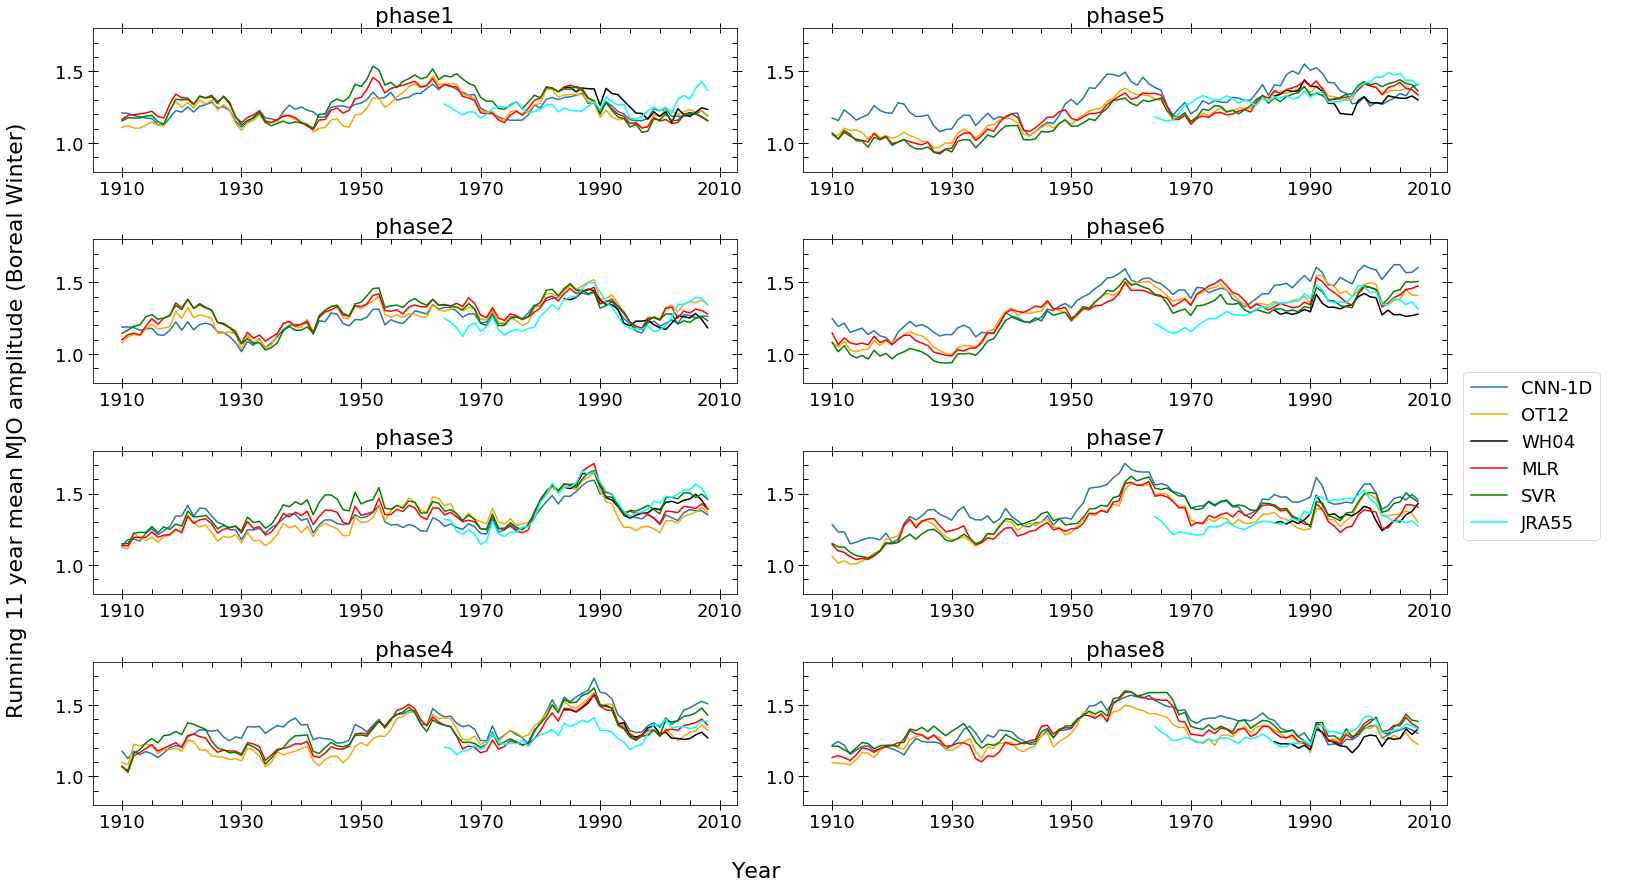

In [47]:
def draw_amplitude_trend():
    window = 11;
    ww     = 2*(window//2);

    list1  = [0,1,2,3,4,6]

    fig,ax  = plt.subplots(4,2,figsize=(20,12))
    plt.rcParams['font.weight'] = 'normal'
    plt.rcParams['font.size'] = 18
    plt.rcParams['image.cmap'] = 'seismic'

    c       = ['C0','orange','k','r','g','cyan']

    kk    =   0
    
    list = np.arange(1910,2019,20).tolist()
    s    = [str(i) for i in list] 
    mean_phase_trend = np.zeros((8,6))
    
    lab = ['CNN-1D','OT12','WH04','MLR','SVR','','JRA55']
    
    for k in list1:
        if k==2:
            aa_winter,phase_amp_winter = winter_amp(df_phase_all.iloc[:,k],df_amp_all.iloc[:,k],1979,2014) 
        elif k==6:
            aa_winter,phase_amp_winter = winter_amp(df_phase_all.iloc[:,k],df_amp_all.iloc[:,k],1959,2014)
        else:
            aa_winter,phase_amp_winter = winter_amp(df_phase_all.iloc[:,k],df_amp_all.iloc[:,k],1905,2014)

        cmap= c[kk]
        
        for i in np.arange(8):
            temp1 = phase_amp_winter[:,i]
    #         temp1 =  temp1[np.logical_not(np.isnan(temp1))]
            temp = smooth(temp1,window_len=window,window='flat')[ww:-ww]
            res = stats.linregress(np.arange(1,len(temp)+1),temp)
            mean_phase_trend[i,kk] = res[0]
            if i<4:
                ax[i,0].plot(np.arange(99-len(temp),99),temp,color=cmap,label=lab[k])
                ax[i,0].set_ylim([0.8,1.8])
                ax[i,0].set_xticks(np.arange(0,109,20))
                ax[i,0].set_xticklabels(s)
                ax[i,0].set_title("phase"+str(i+1))
                ax[i,0].xaxis.set_minor_locator(AutoMinorLocator())
                ax[i,0].yaxis.set_minor_locator(AutoMinorLocator())
                # plt.gcf().autofmt_xdate() # Rotation
                ax[i,0].tick_params(which='major', length=10, width=1, direction='inout')
                ax[i,0].tick_params(which='minor', length=5, width=1, direction='in')

                ax[i,0].xaxis.set_ticks_position('both')  # Adding ticks to both top and bottom
                ax[i,0].xaxis.set_tick_params(direction='inout', which='top') 
                ax[i,0].yaxis.set_ticks_position('both')  # Adding ticks to both top and bottom
                ax[i,0].yaxis.set_tick_params(direction='inout', which='right')
            else:
                ax[i-4,1].plot(np.arange(99-len(temp),99),temp,color=cmap,label=lab[k])
                ax[i-4,1].set_ylim([0.8,1.8])
                ax[i-4,1].set_xticks(np.arange(0,109,20))
                ax[i-4,1].set_xticklabels(s)
                ax[i-4,1].set_title("phase"+str(i+1))
                ax[i-4,1].xaxis.set_minor_locator(AutoMinorLocator())
                ax[i-4,1].yaxis.set_minor_locator(AutoMinorLocator())
                # plt.gcf().autofmt_xdate() # Rotation
                ax[i-4,1].tick_params(which='major', length=10, width=1, direction='inout')
                ax[i-4,1].tick_params(which='minor', length=5, width=1, direction='in')

                ax[i-4,1].xaxis.set_ticks_position('both')  # Adding ticks to both top and bottom
                ax[i-4,1].xaxis.set_tick_params(direction='inout', which='top') 
                ax[i-4,1].yaxis.set_ticks_position('both')  # Adding ticks to both top and bottom
                ax[i-4,1].yaxis.set_tick_params(direction='inout', which='right')
               
               
                    
        kk=kk+1
    
    fig.text(0.5, -0.03, 'Year', ha='center',fontsize=22)
    fig.text(-0.02, 0.5, 'Running 11 year mean MJO amplitude (Boreal Winter)', va='center', rotation='vertical',fontsize=22)
    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc='center left', bbox_to_anchor=(1.01, 0.5))
    fig.tight_layout()
    plt.show()
    fig.savefig('/home/cccr/supriyo/panini/jgrjd_figure/modified_revision/jgrjd_figure2.jpg',dpi=300,bbox_inches='tight')
draw_amplitude_trend()


## Average trend value in winter based on 6 indices (1905-2015)

0.04436538152479407 0.6147153506262764
0.1323518101704838 0.17136919996490288
0.22389885510968188 0.03717130901256403
0.22659940811202087 0.021033860751753026
0.32153613624125654 0.0002954567624757494
0.3582588084286929 0.00032856866526133154
0.2245586651797407 0.01565651171503835
0.11937939923155293 0.1735843064865968


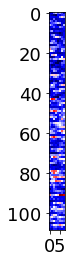

In [27]:
def print_amplitude_trend():
    window = 11;ww=2*(window//2)

    list1  = [0,1,2,3,4,6]

    c=['C0','orange','k','r','g','cyan']

    kk=0
    list = np.arange(1910,2009,20).tolist()
    s = [str(i) for i in list] 

    mean_phase = np.zeros((6,109,8))
    mean_phase.fill(np.nan)

    for k in list1:
        if k==2:
            aa_winter,phase_amp_winter = winter_amp(df_phase_all.iloc[:,k],df_amp_all.iloc[:,k],1979,2014)
        elif k==6:
            aa_winter,phase_amp_winter = winter_amp(df_phase_all.iloc[:,k],df_amp_all.iloc[:,k],1959,2014)
        else:
            aa_winter,phase_amp_winter = winter_amp(df_phase_all.iloc[:,k],df_amp_all.iloc[:,k],1905,2014)

        mean_phase[kk,-len(phase_amp_winter):,:] = phase_amp_winter

        kk+=1

    mm = np.nanmean(mean_phase,axis=0)

    for i in np.arange(8):
        temp1 =mm[:,i]*1
        temp = smooth(temp1,window_len=window,window='flat')[ww:-ww]
        res = stats.linregress(np.arange(1,len(temp1)+1),temp1)
        print(res[0]*100,res[3])
        
    plt.imshow(mm)    
print_amplitude_trend()

## (1959-2015)

-0.28008505687739094 0.00013554724975390326
-0.0044458306081121895 0.9615496937582667
0.3274017017913896 0.009399215683192633
0.25304047110380806 0.015949412927240537
0.40164673030125647 3.029256514520829e-10
0.21016043271038395 7.455890284333204e-05
-0.0018107612149521745 0.9753521287065798
-0.1997369765948545 0.0023520062899040858


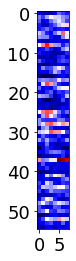

In [28]:
def print_amplitude_trend_short():
    window = 11;ww=2*(window//2)

    list1  = [0,1,2,3,4,6]

    c=['C0','orange','k','r','g','cyan']

    kk=0
    list = np.arange(1910,2009,20).tolist()
    s = [str(i) for i in list] 

    mean_phase = np.zeros((6,55,8))

    mean_phase.fill(np.nan)

    for k in list1:
        if k==2:
            aa_winter,phase_amp_winter = winter_amp(df_phase_all.iloc[:,k],df_amp_all.iloc[:,k],1979,2014)
        elif k==6:
            aa_winter,phase_amp_winter = winter_amp(df_phase_all.iloc[:,k],df_amp_all.iloc[:,k],1959,2014)
        else:
            aa_winter,phase_amp_winter = winter_amp(df_phase_all.iloc[:,k],df_amp_all.iloc[:,k],1959,2014)

        mean_phase[kk,-len(phase_amp_winter):,:] = phase_amp_winter

        kk+=1

    mm = np.nanmean(mean_phase,axis=0)

    for i in np.arange(8):
        temp1 =mm[:,i]*1
        temp = smooth(temp1,window_len=window,window='flat')[ww:-ww]
        res = stats.linregress(np.arange(1,len(temp)+1),temp)
        print(res[0]*100,res[3])
        
    plt.imshow(mm)    
print_amplitude_trend_short()

## SUmmer lines

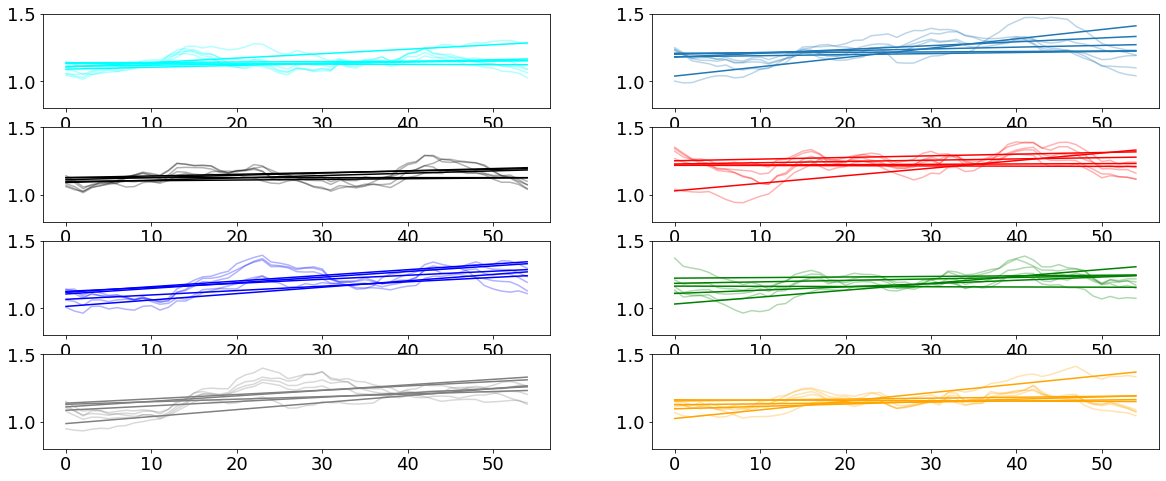

In [29]:
list1  = [0,1,3,4,6]
fig,ax= plt.subplots(4,2,figsize=(20,8))

for k in list1:
    aa_summer,phase_amp_summer = summer_amp(df_phase_all.iloc[:,k],df_amp_all.iloc[:,k],1959,2014)
    c=['cyan','k','b','grey','C0','r','g','orange']

    for i in np.arange(8):
        temp = smooth(phase_amp_summer[:,i],window_len=11,window='flat')[5:-5]
        res = stats.linregress(np.arange(1,len(temp)+1),temp)
        if i<4:
            ax[i,0].plot(res[0]*np.arange(1,len(temp)+1)+res[1],color=c[i],label=str(i+1))
            ax[i,0].plot(temp,color=c[i],alpha=0.3)
            ax[i,0].set_ylim([0.8,1.5])

        else:
            ax[i-4,1].plot(res[0]*np.arange(1,len(temp)+1)+res[1],color=c[i],label=str(i+1))
            ax[i-4,1].plot(temp,color=c[i],alpha=0.3)
            ax[i-4,1].set_ylim([0.8,1.5])


## Winter Lines

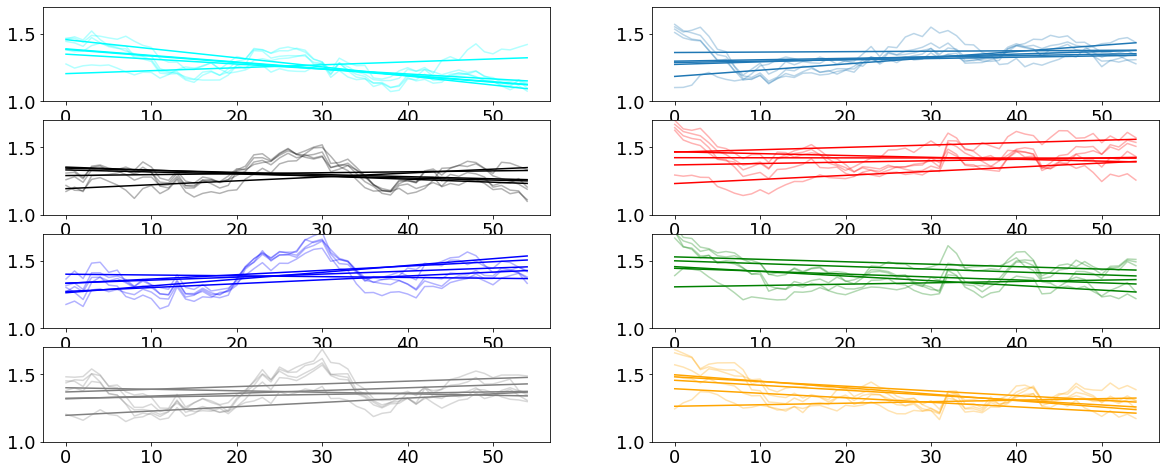

In [30]:
list1  = [0,1,3,4,6]
fig,ax= plt.subplots(4,2,figsize=(20,8))

for k in list1:
    aa_summer,phase_amp_summer = winter_amp(df_phase_all.iloc[:,k],df_amp_all.iloc[:,k],1959,2014)
    c=['cyan','k','b','grey','C0','r','g','orange']

    for i in np.arange(8):
        temp = smooth(phase_amp_summer[:,i],window_len=11,window='flat')[5:-5]
        res = stats.linregress(np.arange(1,len(temp)+1),temp)
        if i<4:
            ax[i,0].plot(res[0]*np.arange(1,len(temp)+1)+res[1],color=c[i],label=str(i+1))
            ax[i,0].plot(temp,color=c[i],alpha=0.3)
            ax[i,0].set_ylim([1,1.7])

        else:
            ax[i-4,1].plot(res[0]*np.arange(1,len(temp)+1)+res[1],color=c[i],label=str(i+1))
            ax[i-4,1].plot(temp,color=c[i],alpha=0.3)
            ax[i-4,1].set_ylim([1,1.7])


## Relation with QBO

In [31]:
def running_correlation(y,x,k):
    from scipy import signal
    run_cor = np.zeros(len(y)-k)
    for i in np.arange(len(y)-k):
        x1= x[i:i+k]
        y1= y[i:i+k]
        x1 = signal.detrend(x1)
        y1 = signal.detrend(y1)
        run_cor[i]= np.corrcoef(x1,y1)[0,1]
    return run_cor



def winter_amp(amp1_rmm,s_year,e_year,opt):
    
    n = e_year-s_year
    
    aa_winter = np.zeros(n,)
    
    for i in np.arange(s_year,e_year,1):
        if opt=='djf':
            aa_winter[i-s_year]= amp1_rmm.loc[str(i)+'-12-01':str(i+1)+'-02-28'].mean()
        elif opt=='ndjfma':
            aa_winter[i-s_year]= amp1_rmm.loc[str(i)+'-11-01':str(i+1)+'-04-30'].mean()
    
    return aa_winter



def read_qbo(s_year,e_year,opt):
    
    qbo=pd.read_fwf('/home/cccr/roxy/panini/JGRJD_PHD_PART_I/DATA/indices/qbo/qbo_index.txt')
    qbo_sel=qbo.set_index('YEAR').loc[s_year:e_year]
    n=e_year-s_year
        
    if opt=='djf':
        qbo_winter=qbo_sel[['JAN','FEB','DEC']].values.ravel()
        k=2;nn=3
    elif opt =='ndjfma':
        qbo_winter=qbo_sel[['JAN','FEB','MAR','APR','NOV','DEC']].values.ravel()
        k=4;nn=6
  
    qbo_winter_mean=np.zeros((n,))
    
    for i in np.arange(n):
        qbo_winter_mean[i]=np.mean(qbo_winter[k:k+nn])
        k=k+nn
    return qbo_winter_mean

def read_qbo_fub(s_year,e_year,opt):
    
    qbo       =  pd.read_csv('qbo_50hpa.csv',header=None)
    qbo.index =  pd.date_range('1953-01-01',periods=806,freq='M')
    qbo_sel   =  qbo[(qbo.index.year>=s_year) &(qbo.index.year<=e_year)]
   
    n=e_year-s_year

    if opt=='djf':
        qbo_winter = qbo[qbo.index.month.isin([12,1,2])].values.ravel()
        k=2;nn=3
    elif opt =='ndjfma':
        qbo_winter = qbo[qbo.index.month.isin([11,12,1,2,3,4])].values.ravel()
        k=4;nn=6

    qbo_winter_mean=np.zeros((n,))

    for i in np.arange(n):
        
        qbo_winter_mean[i]=np.mean(qbo_winter[k:k+nn])
        k=k+nn
    return qbo_winter_mean

In [32]:
s_year1=1949;e_year1=2014
s_year2=1979;e_year2=2014
s_year3=1960;e_year3=2014


aa_winter_conv = winter_amp(df_amp_all.iloc[:,0],s_year1,e_year1,opt='djf')
aa_winter_ol = winter_amp(df_amp_all.iloc[:,1],s_year1,e_year1,opt='djf')
aa_winter_jra = winter_amp(df_amp_all.iloc[:,6],s_year3,e_year3,opt='djf')


aa_winter_wh04 = winter_amp(df_amp_all.iloc[:,2],s_year2,e_year2,opt='djf')

qbo_winter_mean1= read_qbo(s_year1,e_year1,opt='djf')
qbo_winter_mean2= read_qbo(s_year2,e_year2,opt='djf')
qbo_winter_mean3= read_qbo(s_year3,e_year3,opt='djf')


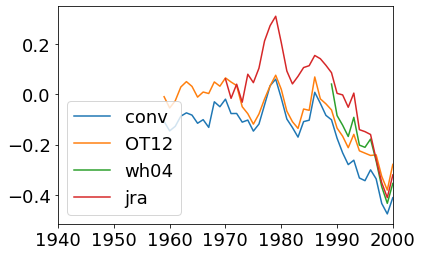

In [33]:
window=20;hw=window//2
plt.plot(np.arange(s_year1+hw,e_year1-hw),running_correlation(aa_winter_conv,qbo_winter_mean1,window),label='conv')
plt.plot(np.arange(s_year1+hw,e_year1-hw),running_correlation(aa_winter_ol,qbo_winter_mean1,window),label='OT12')
plt.plot(np.arange(s_year2+hw,e_year2-hw),running_correlation(aa_winter_wh04,qbo_winter_mean2,window),label='wh04')
plt.plot(np.arange(s_year3+hw,e_year3-hw),running_correlation(aa_winter_jra,qbo_winter_mean3,window),label='jra')
plt.xlim([1940,2000])
plt.legend()

In [34]:
# qbo       =  pd.read_csv('qbo_50hpa.csv',header=None)
# qbo.index =  pd.date_range('1953-01-01',periods=806,freq='M')
# qbo.index.name='time'
# qbo.columns=['qbo']

# ds = qbo.to_xarray()
# climatology = ds.groupby('time.month').mean('time')

# anomalies = ds.groupby('time.month') - climatology
# anomalies = anomalies/np.std(anomalies)

In [35]:
# qbo       =  pd.read_csv('qbo_bronnimann.csv',delim_whitespace=True,header=None)
# qbo.columns=["1","2","qbo"]
# qbo.drop(columns=["1","2"])
# qbo.index =  pd.date_range('1900-01-01',periods=len(qbo),freq='M')